🧬 VARIANTPROJECT - Molecular Exploration Pipeline

📊 Configuration:
   • Variants per molecule: 30
   • Similarity threshold: 0.5
   • Preserve scaffold: True
   • Input molecules: 1

🔬 Generating variants...

   [1/1] Processing: CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O
   ✓ Generated 23 valid variants

✅ Total molecules for evaluation: 24

🧪 Computing molecular descriptors...
📈 Training predictive models...
🎯 Evaluating and ranking molecules...

🏆 TOP 10 RANKED MOLECULES



,SMILES,MolWt,MolLogP,TPSA,RO5_Violations,Composite_Score
0,NN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5,286.331,0.4420,78.95,0,0.955747
1,Oc1ccc2c3c1OC1C(O)C=CC4C(C2)N(O)CCC341,287.315,0.9575,73.16,0,0.899477
2,CN1CCC23c4c5ccc(N)c4OC2C(O)C=CC3C1C5,284.359,1.0747,58.72,0,0.860447
3,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,285.343,1.1981,52.93,0,0.787799
4,Oc1ccc2c3c1OC1C(O)C=CC4C(C2)N(F)CCC341,289.306,1.4528,52.93,0,0.764595
5,CN1CCC23c4c5ccc(O)c4OC2C(N)C=CC3C1C5,284.359,1.1645,58.72,0,0.751181
6,Oc1ccc2c3c1OC1C(O)C=CC4C(C2)N(S)CCC341,303.383,1.4131,52.93,0,0.741777
7,Oc1ccc2c3c1OC1C(O)C=CC4C(C2)N(P)CCC341,303.298,1.3584,52.93,0,0.736919
8,Oc1ccc2c3c1OC1C(O)C=CC4C(C2)N(Cl)CCC341,305.761,1.7221,52.93,0,0.701836
9,Oc1ccc2c3c1OC1C(O)C=CC4C(C2)N(Br)CCC341,350.212,1.8782,52.93,0,0.696107



📊 Generating visualizations...


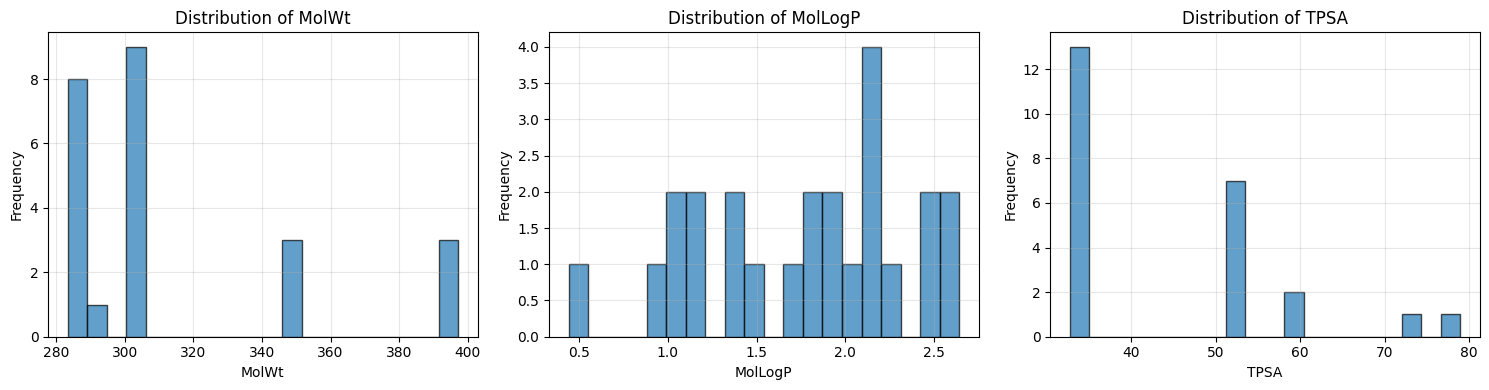

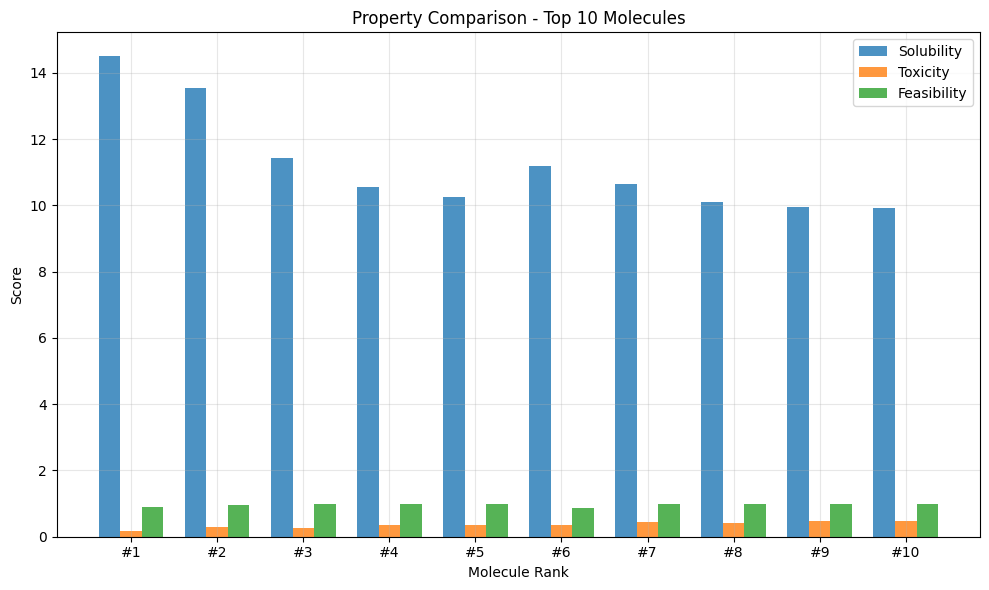


🖼️  Top 5 Molecular Structures (2D):


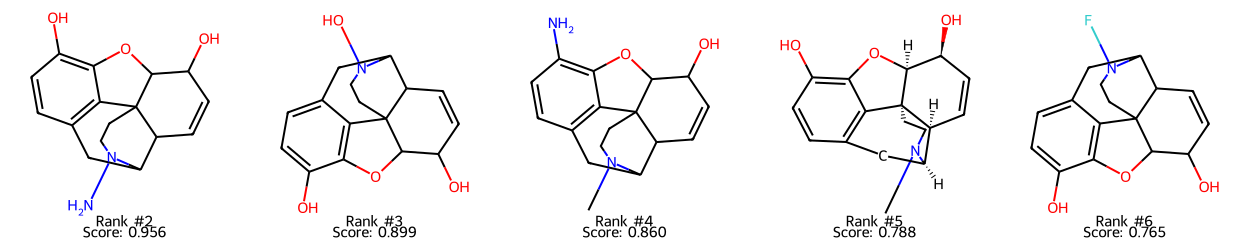


🌐 Generating 3D structures for top 3 molecules...

   Rank #1: NN1CCC23c4c5ccc(O)c4OC2C(O)C=CC3C1C5
   Score: 0.9557 | MW: 286.3 | LogP: 0.44


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


   Rank #2: Oc1ccc2c3c1OC1C(O)C=CC4C(C2)N(O)CCC341
   Score: 0.8995 | MW: 287.3 | LogP: 0.96


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


   Rank #3: CN1CCC23c4c5ccc(N)c4OC2C(O)C=CC3C1C5
   Score: 0.8604 | MW: 284.4 | LogP: 1.07


3Dmol.js failed to load for some reason. Please check your browser console for error messages.


💾 Results exported to: variant_project_results_20251020_001210.csv

✅ EXPLORATION COMPLETE



In [1]:
# =========================================
# VariantProject: Computational Molecular Exploration Tool
# A research-focused platform for AI-assisted chemistry
# =========================================

# =========================================
# 0️⃣ Install Dependencies
# =========================================
!pip install rdkit py3Dmol pandas numpy scikit-learn selfies matplotlib seaborn --quiet

# =========================================
# 1️⃣ Imports
# =========================================
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors, Lipinski, Crippen, Draw, AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.DataStructs import TanimotoSimilarity
from rdkit.Chem import rdMolDescriptors, rdFingerprintGenerator
import py3Dmol
import pandas as pd
import numpy as np
import selfies as sf
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display, clear_output, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')
RDLogger.DisableLog('rdApp.*')

# =========================================
# 2️⃣ Configuration Class
# =========================================
class MolecularExplorerConfig:
    """Configuration parameters for molecular exploration"""

    # Variant generation
    N_VARIANTS = 30
    SIMILARITY_THRESHOLD = 0.5
    MAX_ATTEMPTS_MULTIPLIER = 20

    # Allowed atoms for mutations
    ALLOWED_ATOMS = [6, 7, 8, 9, 15, 16, 17, 35, 53]  # C, N, O, F, P, S, Cl, Br, I

    # Fingerprint parameters
    FP_RADIUS = 2
    FP_NBITS = 2048

    # Scoring weights
    WEIGHT_SOLUBILITY = 0.3
    WEIGHT_TOXICITY = 0.3
    WEIGHT_FEASIBILITY = 0.4

    # 3D optimization
    MMFF_MAX_ITERS = 500

    # Visualization
    VIEWER_WIDTH = 700
    VIEWER_HEIGHT = 500

config = MolecularExplorerConfig()

# =========================================
# 3️⃣ SMILES Validation and Cleaning
# =========================================
class SMILESProcessor:
    """Handles SMILES string validation and cleaning"""

    @staticmethod
    def clean_smiles(smiles):
        """Clean and canonicalize SMILES string"""
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is None:
                return None

            # Remove stereochemistry for canonical form
            smiles_clean = Chem.MolToSmiles(mol, isomericSmiles=False)

            # Verify it can be parsed again
            mol_clean = Chem.MolFromSmiles(smiles_clean)
            return smiles_clean if mol_clean else None
        except Exception as e:
            print(f"⚠️  Error cleaning SMILES '{smiles}': {str(e)}")
            return None

    @staticmethod
    def is_valid_smiles(smiles):
        """Check if SMILES string is valid"""
        try:
            mol = Chem.MolFromSmiles(smiles)
            return mol is not None
        except:
            return False

    @staticmethod
    def to_selfies(smiles):
        """Convert SMILES to SELFIES representation"""
        try:
            return sf.encoder(smiles)
        except:
            return None

    @staticmethod
    def from_selfies(selfies_str):
        """Convert SELFIES back to SMILES"""
        try:
            return sf.decoder(selfies_str)
        except:
            return None

# =========================================
# 4️⃣ Molecular Descriptors Calculator
# =========================================
class MolecularDescriptors:
    """Compute molecular descriptors and properties"""

    @staticmethod
    def compute_basic_descriptors(mol):
        """Compute basic molecular descriptors"""
        if mol is None:
            return [None] * 6

        try:
            return [
                Descriptors.MolWt(mol),
                Crippen.MolLogP(mol),
                Lipinski.NumHDonors(mol),
                Lipinski.NumHAcceptors(mol),
                Lipinski.NumRotatableBonds(mol),
                rdMolDescriptors.CalcTPSA(mol)
            ]
        except:
            return [None] * 6

    @staticmethod
    def compute_extended_descriptors(mol):
        """Compute extended molecular descriptors"""
        if mol is None:
            return {}

        try:
            return {
                'NumAromaticRings': Lipinski.NumAromaticRings(mol),
                'NumSaturatedRings': Lipinski.NumSaturatedRings(mol),
                'NumAliphaticRings': Lipinski.NumAliphaticRings(mol),
                'FractionCSP3': Lipinski.FractionCsp3(mol),
                'NumHeteroatoms': Lipinski.NumHeteroatoms(mol),
                'SASA': rdMolDescriptors.CalcLabuteASA(mol)
            }
        except:
            return {}

    @staticmethod
    def lipinski_rule_of_five(mol):
        """Check Lipinski's Rule of Five compliance"""
        if mol is None:
            return None

        mw = Descriptors.MolWt(mol)
        logp = Crippen.MolLogP(mol)
        hbd = Lipinski.NumHDonors(mol)
        hba = Lipinski.NumHAcceptors(mol)

        violations = 0
        if mw > 500: violations += 1
        if logp > 5: violations += 1
        if hbd > 5: violations += 1
        if hba > 10: violations += 1

        return violations

    @classmethod
    def compute_features(cls, smiles_list):
        """Compute molecular features for a list of SMILES"""
        results = []
        extended_results = []
        ro5_violations = []

        for s in smiles_list:
            mol = Chem.MolFromSmiles(s)

            # Basic descriptors
            basic = cls.compute_basic_descriptors(mol)
            results.append(basic)

            # Extended descriptors
            extended = cls.compute_extended_descriptors(mol)
            extended_results.append(extended)

            # Rule of Five
            ro5 = cls.lipinski_rule_of_five(mol)
            ro5_violations.append(ro5)

        # Create DataFrame
        df = pd.DataFrame(
            results,
            columns=['MolWt', 'MolLogP', 'HBD', 'HBA', 'RotBonds', 'TPSA']
        )
        df['SMILES'] = smiles_list
        df['RO5_Violations'] = ro5_violations

        # Add extended descriptors
        for key in extended_results[0].keys():
            df[key] = [ext.get(key) for ext in extended_results]

        return df

# =========================================
# 5️⃣ Molecular Fingerprints
# =========================================
class FingerprintGenerator:
    """Generate molecular fingerprints for similarity calculations"""

    @staticmethod
    def morgan_fingerprint(smiles, radius=config.FP_RADIUS, nBits=config.FP_NBITS):
        """Generate Morgan (ECFP) fingerprint"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        try:
            return rdMolDescriptors.GetMorganFingerprintAsBitVect(
                mol, radius, nBits=nBits
            )
        except:
            return None

    @staticmethod
    def calculate_similarity(smiles1, smiles2):
        """Calculate Tanimoto similarity between two molecules"""
        fp1 = FingerprintGenerator.morgan_fingerprint(smiles1)
        fp2 = FingerprintGenerator.morgan_fingerprint(smiles2)

        if fp1 is None or fp2 is None:
            return 0.0

        return TanimotoSimilarity(fp1, fp2)

# =========================================
# 6️⃣ Variant Generation Engine
# =========================================
class VariantGenerator:
    """Generate molecular variants with similarity constraints"""

    @staticmethod
    def get_scaffold(mol):
        """Extract Murcko scaffold from molecule"""
        try:
            return MurckoScaffold.GetScaffoldForMol(mol)
        except:
            return None

    @staticmethod
    def mutate_atom(mol, atom_idx, allowed_atoms=config.ALLOWED_ATOMS):
        """Mutate a single atom in the molecule"""
        rw_mol = Chem.RWMol(mol)

        try:
            atom = rw_mol.GetAtomWithIdx(atom_idx)
            current_atomic_num = atom.GetAtomicNum()

            # Choose a different atom
            new_atomic_num = np.random.choice(
                [a for a in allowed_atoms if a != current_atomic_num]
            )
            atom.SetAtomicNum(int(new_atomic_num))

            return rw_mol
        except:
            return None

    @classmethod
    def generate_variants(cls, smiles_input, n_variants=config.N_VARIANTS,
                         similarity_threshold=config.SIMILARITY_THRESHOLD,
                         preserve_scaffold=True):
        """Generate molecular variants using similarity-guided mutations"""

        # Clean input SMILES
        cleaned = SMILESProcessor.clean_smiles(smiles_input)
        if cleaned is None:
            print(f"❌ Invalid SMILES: {smiles_input}")
            return []

        base_mol = Chem.MolFromSmiles(cleaned)
        if base_mol is None:
            return []

        # Get base fingerprint and scaffold
        base_fp = FingerprintGenerator.morgan_fingerprint(cleaned)
        if base_fp is None:
            return []

        base_scaffold = cls.get_scaffold(base_mol) if preserve_scaffold else None
        base_scaffold_smiles = Chem.MolToSmiles(base_scaffold) if base_scaffold else None

        variants = set()
        max_attempts = n_variants * config.MAX_ATTEMPTS_MULTIPLIER
        attempts = 0

        while len(variants) < n_variants and attempts < max_attempts:
            mol = Chem.MolFromSmiles(cleaned)

            if mol.GetNumAtoms() == 0:
                break

            # Random atom mutation
            atom_idx = np.random.randint(0, mol.GetNumAtoms())
            mutated_mol = cls.mutate_atom(mol, atom_idx)

            if mutated_mol is None:
                attempts += 1
                continue

            try:
                new_smiles = Chem.MolToSmiles(mutated_mol, isomericSmiles=False)

                # Validate new SMILES
                if not SMILESProcessor.is_valid_smiles(new_smiles):
                    attempts += 1
                    continue

                # Check similarity
                new_fp = FingerprintGenerator.morgan_fingerprint(new_smiles)
                sim = TanimotoSimilarity(base_fp, new_fp)

                # Check scaffold preservation if required
                scaffold_match = True
                if preserve_scaffold and base_scaffold is not None:
                    new_mol = Chem.MolFromSmiles(new_smiles)
                    new_scaffold = cls.get_scaffold(new_mol)
                    new_scaffold_smiles = Chem.MolToSmiles(new_scaffold) if new_scaffold else None
                    scaffold_match = (new_scaffold_smiles == base_scaffold_smiles)

                # Add variant if it passes all checks
                if sim >= similarity_threshold and scaffold_match:
                    variants.add(new_smiles)

            except Exception as e:
                pass

            attempts += 1

        return list(variants)

# =========================================
# 7️⃣ Machine Learning Models
# =========================================
class MolecularPropertyPredictor:
    """ML models for predicting molecular properties"""

    def __init__(self):
        self.model_solubility = None
        self.model_toxicity = None
        self.scaler = StandardScaler()
        self.is_trained = False

    def train(self, df_features):
        """Train dummy models (replace with real models in production)"""

        # Generate synthetic targets for demonstration
        np.random.seed(42)
        n = len(df_features)

        # Solubility correlates with TPSA and LogP
        df_features['Solubility'] = (
            -0.3 * df_features['MolLogP'].fillna(0) +
            0.2 * df_features['TPSA'].fillna(0) +
            np.random.normal(0, 0.1, n)
        )

        # Toxicity correlates with LogP and molecular weight
        df_features['Toxicity'] = (
            0.2 * df_features['MolLogP'].fillna(0) +
            0.0005 * df_features['MolWt'].fillna(0) +
            np.random.normal(0, 0.1, n)
        )

        # Prepare features
        feature_cols = ['MolWt', 'MolLogP', 'HBD', 'HBA', 'RotBonds', 'TPSA']
        X = df_features[feature_cols].fillna(0)
        X_scaled = self.scaler.fit_transform(X)

        # Train models
        self.model_solubility = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )
        self.model_toxicity = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42
        )

        self.model_solubility.fit(X_scaled, df_features['Solubility'])
        self.model_toxicity.fit(X_scaled, df_features['Toxicity'])

        self.is_trained = True
        return self

    def predict(self, df_features):
        """Predict molecular properties"""
        if not self.is_trained:
            raise ValueError("Models must be trained before prediction")

        feature_cols = ['MolWt', 'MolLogP', 'HBD', 'HBA', 'RotBonds', 'TPSA']
        X = df_features[feature_cols].fillna(0)
        X_scaled = self.scaler.transform(X)

        predictions = {
            'Pred_Solubility': self.model_solubility.predict(X_scaled),
            'Pred_Toxicity': self.model_toxicity.predict(X_scaled)
        }

        return predictions

# =========================================
# 8️⃣ Molecular Evaluator
# =========================================
class MolecularEvaluator:
    """Evaluate and rank molecular variants"""

    @staticmethod
    def calculate_lab_feasibility(df):
        """Calculate synthetic feasibility score"""
        # Simple heuristic based on complexity
        feasibility = np.ones(len(df))

        # Penalize high molecular weight
        feasibility -= 0.3 * (df['MolWt'] > 500).astype(int)

        # Penalize many rotatable bonds
        feasibility -= 0.2 * (df['RotBonds'] > 10).astype(int)

        # Penalize RO5 violations
        feasibility -= 0.15 * df['RO5_Violations'].fillna(0)

        # Add some noise
        feasibility += np.random.normal(0, 0.1, len(df))

        return np.clip(feasibility, 0, 1)

    @staticmethod
    def calculate_composite_score(df):
        """Calculate composite score from multiple factors"""

        # Normalize predictions to [0, 1]
        sol_norm = (df['Pred_Solubility'] - df['Pred_Solubility'].min()) / \
                   (df['Pred_Solubility'].max() - df['Pred_Solubility'].min() + 1e-6)

        tox_norm = 1 - (df['Pred_Toxicity'] - df['Pred_Toxicity'].min()) / \
                   (df['Pred_Toxicity'].max() - df['Pred_Toxicity'].min() + 1e-6)

        # Calculate composite score
        composite = (
            config.WEIGHT_SOLUBILITY * sol_norm +
            config.WEIGHT_TOXICITY * tox_norm +
            config.WEIGHT_FEASIBILITY * df['Lab_Feasibility']
        )

        return composite

    @classmethod
    def evaluate(cls, smiles_list, predictor):
        """Evaluate molecules and return ranked DataFrame"""

        # Compute molecular descriptors
        df = MolecularDescriptors.compute_features(smiles_list)

        # Predict properties
        predictions = predictor.predict(df)
        df['Pred_Solubility'] = predictions['Pred_Solubility']
        df['Pred_Toxicity'] = predictions['Pred_Toxicity']

        # Calculate feasibility
        df['Lab_Feasibility'] = cls.calculate_lab_feasibility(df)

        # Calculate composite score
        df['Composite_Score'] = cls.calculate_composite_score(df)

        # Sort by composite score
        df_sorted = df.sort_values('Composite_Score', ascending=False)

        return df_sorted.reset_index(drop=True)

# =========================================
# 9️⃣ 3D Structure Visualization
# =========================================
class Structure3D:
    """Generate and visualize 3D molecular structures"""

    @staticmethod
    def generate_3d_conformer(smiles):
        """Generate optimized 3D conformer"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        try:
            # Add hydrogens
            mol = Chem.AddHs(mol)

            # Generate 3D coordinates
            AllChem.EmbedMolecule(mol, randomSeed=42)

            # Optimize geometry with MMFF
            AllChem.MMFFOptimizeMolecule(mol, maxIters=config.MMFF_MAX_ITERS)

            return mol
        except:
            return None

    @staticmethod
    def visualize_3d(mol, style='stick', color_scheme='default'):
        """Create interactive 3D visualization"""
        if mol is None:
            return None

        try:
            block = Chem.MolToMolBlock(mol)
            viewer = py3Dmol.view(
                width=config.VIEWER_WIDTH,
                height=config.VIEWER_HEIGHT
            )
            viewer.addModel(block, "mol")

            if style == 'stick':
                viewer.setStyle({'stick': {'colorscheme': color_scheme}})
            elif style == 'sphere':
                viewer.setStyle({'sphere': {'colorscheme': color_scheme}})
            else:
                viewer.setStyle({
                    'stick': {'colorscheme': color_scheme},
                    'sphere': {'scale': 0.3, 'colorscheme': color_scheme}
                })

            viewer.setBackgroundColor('white')
            viewer.zoomTo()

            return viewer
        except:
            return None

# =========================================
# 🔟 Visualization and Reporting
# =========================================
class MolecularVisualizer:
    """Create visualizations and reports"""

    @staticmethod
    def plot_property_distribution(df, properties=['MolWt', 'MolLogP', 'TPSA']):
        """Plot distribution of molecular properties"""
        n_props = len(properties)
        fig, axes = plt.subplots(1, n_props, figsize=(5*n_props, 4))

        if n_props == 1:
            axes = [axes]

        for ax, prop in zip(axes, properties):
            ax.hist(df[prop].dropna(), bins=20, alpha=0.7, edgecolor='black')
            ax.set_xlabel(prop)
            ax.set_ylabel('Frequency')
            ax.set_title(f'Distribution of {prop}')
            ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_score_comparison(df, top_n=10):
        """Compare scores for top molecules"""
        top_mols = df.head(top_n)

        fig, ax = plt.subplots(figsize=(10, 6))

        x = np.arange(len(top_mols))
        width = 0.25

        ax.bar(x - width, top_mols['Pred_Solubility'], width,
               label='Solubility', alpha=0.8)
        ax.bar(x, top_mols['Pred_Toxicity'], width,
               label='Toxicity', alpha=0.8)
        ax.bar(x + width, top_mols['Lab_Feasibility'], width,
               label='Feasibility', alpha=0.8)

        ax.set_xlabel('Molecule Rank')
        ax.set_ylabel('Score')
        ax.set_title(f'Property Comparison - Top {top_n} Molecules')
        ax.set_xticks(x)
        ax.set_xticklabels([f'#{i+1}' for i in range(len(top_mols))])
        ax.legend()
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.show()

    @staticmethod
    def draw_molecules_grid(smiles_list, labels=None, mols_per_row=5):
        """Draw grid of 2D molecular structures"""
        mols = [Chem.MolFromSmiles(s) for s in smiles_list]

        if labels is None:
            labels = [f"Mol {i+1}" for i in range(len(smiles_list))]

        img = Draw.MolsToGridImage(
            mols,
            molsPerRow=mols_per_row,
            subImgSize=(250, 250),
            legends=labels
        )

        return img

# =========================================
# 1️⃣1️⃣ Main Explorer Class
# =========================================
class VariantProject:
    """Main molecular exploration orchestrator"""

    def __init__(self, config=config):
        self.config = config
        self.predictor = MolecularPropertyPredictor()
        self.results = None
        self.input_smiles = []

    def explore(self, smiles_list, n_variants=None, similarity_threshold=None,
                preserve_scaffold=True, show_visualizations=True, export_csv=True):
        """
        Main exploration pipeline

        Parameters:
        -----------
        smiles_list : list
            List of input SMILES strings
        n_variants : int
            Number of variants to generate per input molecule
        similarity_threshold : float
            Minimum Tanimoto similarity to input molecule
        preserve_scaffold : bool
            Whether to preserve Murcko scaffold
        show_visualizations : bool
            Whether to display plots
        export_csv : bool
            Whether to export results to CSV
        """

        clear_output()

        # Set defaults
        if n_variants is None:
            n_variants = self.config.N_VARIANTS
        if similarity_threshold is None:
            similarity_threshold = self.config.SIMILARITY_THRESHOLD

        self.input_smiles = smiles_list

        print("=" * 70)
        print("🧬 VARIANTPROJECT - Molecular Exploration Pipeline")
        print("=" * 70)
        print(f"\n📊 Configuration:")
        print(f"   • Variants per molecule: {n_variants}")
        print(f"   • Similarity threshold: {similarity_threshold}")
        print(f"   • Preserve scaffold: {preserve_scaffold}")
        print(f"   • Input molecules: {len(smiles_list)}")

        # Generate variants
        print(f"\n🔬 Generating variants...")
        all_variants = []

        for idx, smiles_input in enumerate(smiles_list, 1):
            print(f"\n   [{idx}/{len(smiles_list)}] Processing: {smiles_input}")

            variants = VariantGenerator.generate_variants(
                smiles_input,
                n_variants=n_variants,
                similarity_threshold=similarity_threshold,
                preserve_scaffold=preserve_scaffold
            )

            print(f"   ✓ Generated {len(variants)} valid variants")

            # Include input molecule
            all_variants.append(smiles_input)
            all_variants.extend(variants)

        if len(all_variants) == 0:
            print("\n❌ No valid variants generated. Try different parameters.")
            return None

        print(f"\n✅ Total molecules for evaluation: {len(all_variants)}")

        # Compute features and train models
        print(f"\n🧪 Computing molecular descriptors...")
        df_features = MolecularDescriptors.compute_features(all_variants)

        print(f"📈 Training predictive models...")
        self.predictor.train(df_features)

        # Evaluate molecules
        print(f"🎯 Evaluating and ranking molecules...")
        self.results = MolecularEvaluator.evaluate(all_variants, self.predictor)

        # Display results
        print(f"\n{'='*70}")
        print(f"🏆 TOP 10 RANKED MOLECULES")
        print(f"{'='*70}\n")

        display(self.results.head(10)[[
            'SMILES', 'MolWt', 'MolLogP', 'TPSA',
            'RO5_Violations', 'Composite_Score'
        ]])

        # Visualizations
        if show_visualizations:
            print(f"\n📊 Generating visualizations...")

            # Property distributions
            MolecularVisualizer.plot_property_distribution(
                self.results,
                properties=['MolWt', 'MolLogP', 'TPSA']
            )

            # Score comparison
            MolecularVisualizer.plot_score_comparison(self.results, top_n=10)

            # 2D structures of top molecules
            print(f"\n🖼️  Top 5 Molecular Structures (2D):")
            top_smiles = self.results.head(5)['SMILES'].tolist()
            top_labels = [f"Rank #{i+1}\nScore: {score:.3f}"
                         for i, score in enumerate(self.results.head(5)['Composite_Score'], 1)]
            img = MolecularVisualizer.draw_molecules_grid(top_smiles, labels=top_labels)
            display(img)

        # 3D visualization of top 3
        print(f"\n🌐 Generating 3D structures for top 3 molecules...")
        top3 = self.results.head(3)

        for idx, row in top3.iterrows():
            print(f"\n   Rank #{idx+1}: {row['SMILES']}")
            print(f"   Score: {row['Composite_Score']:.4f} | MW: {row['MolWt']:.1f} | LogP: {row['MolLogP']:.2f}")

            mol3d = Structure3D.generate_3d_conformer(row['SMILES'])
            if mol3d:
                viewer = Structure3D.visualize_3d(mol3d, style='stick')
                if viewer:
                    viewer.show()
            else:
                print("   ⚠️  Could not generate 3D structure")

        # Export results
        if export_csv:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"variant_project_results_{timestamp}.csv"
            self.results.to_csv(filename, index=False)
            print(f"\n💾 Results exported to: {filename}")

        print(f"\n{'='*70}")
        print(f"✅ EXPLORATION COMPLETE")
        print(f"{'='*70}\n")

        return self.results

    def get_top_molecules(self, n=10):
        """Get top N molecules from results"""
        if self.results is None:
            print("⚠️  No results available. Run explore() first.")
            return None

        return self.results.head(n)

    def export_top_molecules(self, n=10, filename=None):
        """Export top N molecules to CSV"""
        if self.results is None:
            print("⚠️  No results available. Run explore() first.")
            return

        top_mols = self.results.head(n)

        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"top_{n}_molecules_{timestamp}.csv"

        top_mols.to_csv(filename, index=False)
        print(f"✅ Top {n} molecules exported to: {filename}")

# =========================================
# 1️⃣2️⃣ Run VariantProject
# =========================================

def main():
    """Main execution function"""

    # Get user input
    print("=" * 70)
    print("🧬 VARIANTPROJECT - AI-Assisted Molecular Exploration")
    print("=" * 70)
    print("\nEnter SMILES strings for molecular exploration")
    print("Examples:")
    print("  • Aspirin: CC(=O)Oc1ccccc1C(=O)O")
    print("  • Caffeine: CN1C=NC2=C1C(=O)N(C(=O)N2C)C")
    print("  • Simple alkane: CCCCCCCC\n")

    smiles_input_raw = input("\nEnter SMILES (comma-separated): ")
    smiles_list = [s.strip() for s in smiles_input_raw.split(",") if s.strip()]

    if not smiles_list:
        print("❌ No valid SMILES provided. Exiting.")
        return

    # Optional parameters
    print("\n⚙️  Optional Parameters (press Enter for defaults):")

    try:
        n_var = input(f"Number of variants per molecule [{config.N_VARIANTS}]: ")
        n_variants = int(n_var) if n_var else config.N_VARIANTS
    except:
        n_variants = config.N_VARIANTS

    try:
        sim_thresh = input(f"Similarity threshold (0-1) [{config.SIMILARITY_THRESHOLD}]: ")
        similarity_threshold = float(sim_thresh) if sim_thresh else config.SIMILARITY_THRESHOLD
    except:
        similarity_threshold = config.SIMILARITY_THRESHOLD

    preserve_scaffold = input("Preserve molecular scaffold? [Y/n]: ").lower() != 'n'

    # Initialize and run explorer
    explorer = VariantProject()

    results = explorer.explore(
        smiles_list=smiles_list,
        n_variants=n_variants,
        similarity_threshold=similarity_threshold,
        preserve_scaffold=preserve_scaffold,
        show_visualizations=True,
        export_csv=True
    )

    return explorer, results

# =========================================
# 1️⃣3️⃣ Alternative: Quick Start Function
# =========================================

def quick_explore(smiles_list, n_variants=30, similarity_threshold=0.5):
    """
    Quick exploration with default parameters

    Example usage:
    >>> results = quick_explore(['CC(=O)Oc1ccccc1C(=O)O', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'])
    """
    explorer = VariantProject()
    results = explorer.explore(
        smiles_list=smiles_list,
        n_variants=n_variants,
        similarity_threshold=similarity_threshold,
        preserve_scaffold=True,
        show_visualizations=True,
        export_csv=True
    )
    return explorer, results

# =========================================
# 1️⃣4️⃣ Execute Main Program
# =========================================

if __name__ == "__main__":
    # Run the interactive main function
    explorer, results = main()

    # Uncomment below for quick testing with predefined molecules
    # explorer, results = quick_explore([
    #     'CC(=O)Oc1ccccc1C(=O)O',  # Aspirin
    #     'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'  # Caffeine
    # ])



